In [1]:
''' 
This Script displays the image predictions for a loaded model

This script does conditional image generation on MNIST, using a diffusion model

This code is modified from,
https://github.com/cloneofsimo/minDiffusion

Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239

The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598

This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Modelswith Deep Language Understanding',
https://arxiv.org/abs/2205.11487

'''

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

import numpy as np
import multiprocessing
import time
import scipy


# for dataset
import os
from PIL import Image
import pickle
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from astropy.io import fits

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    # def __init__(self, in_channels, n_feat = 256, n_classes=10):
    def __init__(self, in_channels, n_feat = 256):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        
        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(12, 2*n_feat)
        self.contextembed2 = EmbedFC(12, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):

        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = c.reshape((c.shape[0], 12))
        
        # mask out context if context_mask == 1
        context_mask = context_mask.reshape((x.shape[0], 12))
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        self.sqrtab = self.sqrtab.to(self.device)
        self.sqrtmab = self.sqrtmab.to(self.device)

        x_t = (
            self.sqrtab[_ts, None].reshape((x.shape[0], 1, 1, 1)) * x
            + self.sqrtmab[_ts, None].reshape((x.shape[0], 1, 1, 1)) * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))


    def sample_c(self, c_i, n_sample, size, device):
        '''
        this is different than the function sample above
        this always uses classifer guidance for diffusion, so no need to concat 2 versions of 
        dataset or have a guidance scale w. Also context_mask=0 always since no mask used

        taking n_sample samples of EACH datapoint. There are n_datapoint datapoints
        '''
        n_datapoint = c_i.shape[0]

        x_i = torch.randn(n_datapoint*n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        
        # repeat c_i n_sample times to make up a row
        c_i = torch.cat([c_i[idx:idx+1].repeat(n_sample, 1, 1) for idx in range(n_datapoint)]).to(device)
        
        # don't drop context at test time. To include context make context_mask all 0's
        context_mask = torch.zeros_like(c_i).to(device)

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_datapoint*n_sample,1,1,1)

            z = torch.randn(n_datapoint*n_sample, *size).to(device) if i > 1 else 0

            # compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [3]:
# TESS Dataset

class TESSDataset(Dataset):
    def __init__(self, angle_filename, ccd_folder, model_dir, image_shape, num_processes=20, above_sunshade=True, validation_dataset=True):
        start_time = time.time()
        
        # get data
        self.angle_folder = "/pdo/users/jlupoiii/TESS/data/angles/"
        self.ccd_folder = ccd_folder
        self.image_shape = image_shape
        self.model_dir = model_dir
        
        # Create a pool of processes
        pool = multiprocessing.Pool(processes=num_processes)

        # data matrices
        # X = []
        # Y = []
        # ffi_nums = []
        self.data = []
        self.labels = []
        self.ffi_nums = []

        # get angles_dic
        self.angles_dic = pickle.load(open(self.angle_folder+angle_filename, "rb"))

        # get list of ffi's that were used as the validation set for the model
        validation_ffinumbers_list = pickle.load(open(self.model_dir+"validation_dataset_ffinumbers.pkl", "rb"))
        training_ffinumbers_list = pickle.load(open(self.model_dir+"training_dataset_ffinumbers.pkl", "rb"))
        validation_ffinumbers_set = set(validation_ffinumbers_list)
        training_ffinumbers_set = set(training_ffinumbers_list)
            
        files = []
        count = 0
        for filename in os.listdir(self.ccd_folder):
            ffi_num = filename[18:18+8]
            if ffi_num in self.angles_dic.keys(): # makes sure that fi_num exists
                if (self.angles_dic[ffi_num]['below_sunshade'] != above_sunshade) and (validation_dataset and ffi_num in validation_ffinumbers_set):
                    # above sunshade, in validation set
                    files.append(filename)
                elif (self.angles_dic[ffi_num]['below_sunshade'] != above_sunshade) and (not validation_dataset and ffi_num in training_ffinumbers_set):
                    # above sunshade, in training set
                    files.append(filename)
                elif (self.angles_dic[ffi_num]['below_sunshade'] != above_sunshade) and (validation_dataset and ffi_num in validation_ffinumbers_set):
                    # below sunshade, in validation set
                    files.append(filename)
                elif  (self.angles_dic[ffi_num]['below_sunshade'] != above_sunshade) and (not validation_dataset and ffi_num in training_ffinumbers_set):
                    # below sunshade, in training set
                    files.append(filename)
    

        pbar_files = tqdm(files)
        results = []
        # print(f"About to start loading images to a list at time {(time.time() - start_time):.2f}")
        results = pool.map(self.load_images_worker, pbar_files)
        # print(f"made list of all processed results at time {(time.time() - start_time):.2f}")

        # Process the results
        pbar_results = tqdm(results)
        for x, y, ffi_num in pbar_results:
            if x is not None:
                self.data.append(x)
                self.labels.append(y)
                self.ffi_nums.append(ffi_num)
        
        pool.close()
        pool.join()

        end_time = time.time()
        total_time = end_time - start_time
        print(f"Time to build dataset of {len(self.data)} points: {total_time:.2f} seconds")

    def load_images_worker(self, filename):
        if len(filename) < 40 or filename[27] != '3': 
            return None, None, None

        image_arr = pickle.load(open(self.ccd_folder + filename, "rb"))
        ffi_num = filename[18:18+8]
        try:
            angles = self.angles_dic[ffi_num]
        except KeyError:
            return None, None, None
            
        x = np.array([angles['1/ED'], angles['1/MD'], angles['1/ED^2'], angles['1/MD^2'], angles['Eel'], angles['Eaz'], angles['Mel'], angles['Maz'], angles['E3el'], angles['E3az'], angles['M3el'], angles['M3az']])
        x = Image.fromarray(x)
        y = image_arr.flatten()
        y = Image.fromarray(y)

        return x, y, ffi_num


    def __len__(self):
        return len(self.data)
        

    def __getitem__(self, idx):
        angles_image = self.data[idx]
        ffi_image = self.labels[idx]
        ffi_num = self.ffi_nums[idx]
        orbit = self.angles_dic[ffi_num]["orbit"]

        transform = transforms.Compose([
            transforms.ToTensor(),
            lambda s: s.reshape(1, 12)
        ])
        target_transform = transforms.Compose([
            lambda s: np.array(s),
            # lambda s: s.reshape((1024,1024)),
            lambda s: s.reshape(self.image_shape),
            transforms.ToTensor()
        ])

        angles_image = transform(angles_image)
        ffi_image = target_transform(ffi_image)

        # X: 1x12 vector of angles and distances
        # Y: 16x16 image (or other image size)
        return {"x":angles_image, "y":ffi_image, "ffi_num": ffi_num, "orbit": orbit}


# MAKE DATASET
# we are calculating Y GIVEN X
angle_filename = 'angles_O11-54_data_dic.pkl'
ccd_folder = "/pdo/users/jlupoiii/TESS/data/processed_images_im128x128/"
model_dir = "/pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im128x128_multipleGPUs_1/"
image_shape = (128,128)
num_processes = 40
tess_dataset = TESSDataset(angle_filename=angle_filename, ccd_folder=ccd_folder, model_dir=model_dir, image_shape=image_shape, num_processes=num_processes, above_sunshade=True, validation_dataset=True)

print(f"dataset is {len(tess_dataset)} long")
print(tess_dataset[0]['x'].shape)
print(tess_dataset[0]['y'].shape)
print(tess_dataset[0]['ffi_num'])
print(tess_dataset[0]['orbit'])


100%|███████████████████████████████████| 3477/3477 [00:00<00:00, 882623.92it/s]

Time to build dataset of 3477 points: 11.55 seconds
dataset is 3477 long
torch.Size([1, 12])
torch.Size([1, 128, 128])
00008872
15


In [4]:
# angle_filename = 'angles_O11-54_data_dic.pkl'
# ccd_folder = "/pdo/users/jlupoiii/TESS/data/processed_images_im128x128/"
# image_shape = (128,128)
# num_processes = 40

# valid_above_dataset = TESSDataset(angle_filename=angle_filename, ccd_folder=ccd_folder, model_dir=model_dir, image_shape=image_shape, num_processes=num_processes, above_sunshade=True, validation_dataset=True)
# # valid_below_dataset = TESSDataset(angle_filename=angle_filename, ccd_folder=ccd_folder, model_dir=model_dir, image_shape=image_shape, num_processes=num_processes, above_sunshade=False, validation_dataset=True)
# # training_above_dataset = TESSDataset(angle_filename=angle_filename, ccd_folder=ccd_folder, model_dir=model_dir, image_shape=image_shape, num_processes=num_processes, above_sunshade=True, validation_dataset=False)
# # training_below_dtaset =TESSDataset(angle_filename=angle_filename, ccd_folder=ccd_folder, model_dir=model_dir, image_shape=image_shape, num_processes=num_processes, above_sunshade=False, validation_dataset=False)

# # below sunshade: 17310 
# # above sunshade: 8650 
# # total: 25960
# # training ratio: 0.8
# print('valid_above', len(valid_above_dataset))
# # print('valid_below', len(valid_below_dataset))
# # print('training_above', len(training_above_dataset))
# # print('training_below', len(training_below_dtaset))

# # note that we only want to plot images in the validation set (unseen by model) and above the sunshade (will likely have light scatter)

In [5]:
class TESS_4096_original_images:
    def __init__(self):
        self.ffi_to_fits_filepath = {}
        
        fits_folder_paths = []
        for i in range(9, 63):
            fits_folder_paths.append("/pdo/users/roland/SL_data/O" + str(i) + "_data/")

        for fits_folder_path in fits_folder_paths:
            orbit = fits_folder_path[27:29] if fits_folder_path[29]=='_' else fits_folder_path[27:28]
            for fits_filename in os.listdir(fits_folder_path):
                # skips files that we do not want - ex: not camera 3
                if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':
                    ffi_num = fits_filename[18:26]
                    self.ffi_to_fits_filepath[ffi_num] = os.path.join(fits_folder_path, fits_filename)

    def __len__(self):
        return len(self.ffi_to_fits_filepath)

    def __getitem__(self, ffi_num):
        rows_to_delete = range(2048, 2108)
        columns_to_delete = list(range(0, 44)) + list(range(2092, 2180)) + list(range(4228, 4272))
        
        image = fits.getdata(self.ffi_to_fits_filepath[ffi_num], ext=0) # load data
        image = np.delete(image, rows_to_delete, axis=0) # remove black rows
        image = np.delete(image, columns_to_delete, axis=1) # remove black columns
        image = image.astype(np.float64) # need to change datatype from i4 to float64
        image *= 1/633118 # scaling must match preprocessing scaling
        # also must update this when we divide by exposure time

        image_tensor = torch.tensor(image)
        return image_tensor


In [6]:
class TESS_4096_processed_images:
    def __init__(self):
        self.ffi_to_pkl_filepath = {}
        
        pkl_folder_path = "/pdo/users/jlupoiii/TESS/data/processed_images_im4096x4096/"
        for pkl_filename in os.listdir(pkl_folder_path):
                ffi_num = pkl_filename[18:26]
                self.ffi_to_pkl_filepath[ffi_num] = os.path.join(pkl_folder_path, pkl_filename)

    def __len__(self):
        return len(self.ffi_to_fits_filepath)

    def __getitem__(self, ffi_num):
        with open(self.ffi_to_pkl_filepath[ffi_num], 'rb') as file:
            return pickle.load(file)


# def get_processed_4096x4096(self, ffi_num):
#     fits_folder

model directory: /pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im128x128_multipleGPUs_1/model_epoch1499.pth



100%|██████████████████████████████████████| 3477/3477 [00:09<00:00, 351.93it/s]

100%|███████████████████████████████████| 3477/3477 [00:00<00:00, 263846.63it/s]


Time to build dataset of 3477 points: 18.92 seconds
beginnging evaluation for ffi number 00009342, orbit 15

<class 'numpy.ndarray'> (37, 2, 1, 128, 128)
<class 'numpy.ndarray'> (37, 1, 1, 128, 128)


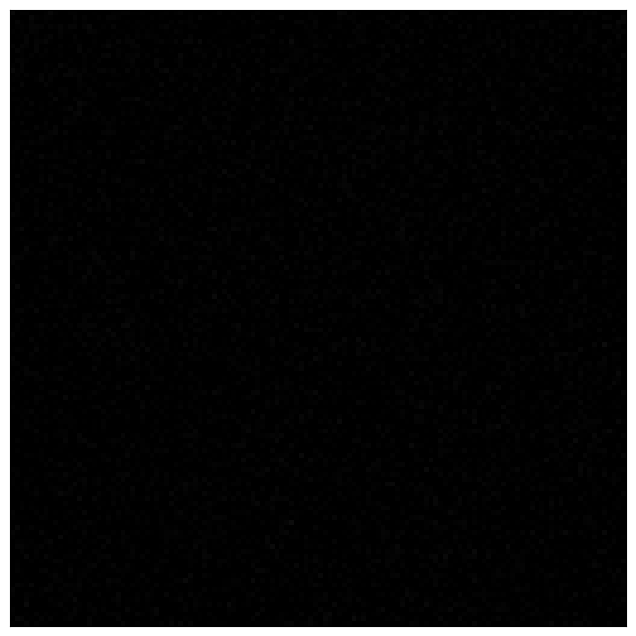

In [45]:
def display_TESS_single_model():
    # hardcoding these here - make sure these match the parameters of the model being loaded
    # model parameters
    n_T = 600
    device = "cuda:4"
    n_feat = 256
    lrate = 1e-4
    model_dir = "/pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im128x128_multipleGPUs_1/"
    model_state_dic_filename = "model_epoch1499.pth"
    eval_folder = 'eval/'
    os.makedirs(os.path.join(model_dir, eval_folder), exist_ok=True)
    
    # dataset parameters - eventually make it so we load validation/training set that is saved specifically to the model
    angle_filename = 'angles_O11-54_data_dic.pkl'
    ccd_folder = "/pdo/users/jlupoiii/TESS/data/processed_images_im128x128/"
    image_shape = (128,128)
    num_processes = 40

    N = 2 # number of samples to predict per datapoint

    # loading class that handles getting the 4096x4096 images based on the ffi
    ffi_to_4096originalimage = TESS_4096_original_images()
    ffi_to_4096processedimage = TESS_4096_processed_images()

    # define model
    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    
    # load a model
    ddpm.load_state_dict(torch.load(os.path.join(model_dir, model_state_dic_filename)))
    ddpm.to(device)

    print('model directory:', os.path.join(model_dir, model_state_dic_filename))

    # load daatset and dataloader for images in validation set that are above the sunshade
    dataset = TESSDataset(angle_filename=angle_filename, ccd_folder=ccd_folder, model_dir=model_dir, image_shape=image_shape, num_processes=num_processes, above_sunshade=True, validation_dataset=True)
    # dataset = valid_above_dataset
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, drop_last=True)

    ddpm.eval()
    with torch.no_grad():
        count = 0
        for data_dic in dataloader:
            ffi_num = data_dic['ffi_num'][0]
            orbit = data_dic['orbit'][0]
            x = data_dic['y'].to(device)
            c = data_dic['x'].to(device)

            print(f'beginnging evaluation for ffi number {ffi_num}, orbit {orbit}')
    
            # generate samples using model, each sample is an x_i
            x_gen, x_gen_store = ddpm.sample_c(c, N, (1, image_shape[0], image_shape[1]), device)
            
            # get original 4096x4096 image
            X = ffi_to_4096originalimage[ffi_num]

            # get processed 4096x4096 image
            X_proc = ffi_to_4096processedimage[ffi_num]
            X_proc = torch.tensor(X_proc)
            
            ############## GIFS #############
            # only animates a single sample(don't need 100!)
            x_gen_store = x_gen_store[:, 0:1, :, :, :]
            # create gif of images evolving over time, based on x_gen_store
            fig, axs = plt.subplots(nrows=1, ncols=1,sharex=True,sharey=True, figsize=(8,8))# ,figsize=(8,3))
            def animate_diff(i, x_gen_store):
                print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                img = axs.imshow(x_gen_store[i, 0, 0], cmap='gray', vmin=0, vmax=1)
                axs.set_xticks([])
                axs.set_yticks([])
                return img,
            ani = FuncAnimation(fig, animate_diff, fargs=[np.clip(x_gen_store, 0, 1)],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0]) 
            save_file = os.path.join(model_dir, eval_folder, f"gif_sample_{count}_{ffi_num}.gif")
            ani.save(save_file, dpi=100, writer=PillowWriter(fps=5))
            print('Done animating GIF')
            ############## GIFS #############

            bar_x = torch.mean(x_gen.cpu(), dim=0) # Mean prediction for model's predictions

            sigma_x = torch.std(x_gen.cpu(), dim=0) # Standard deviation of prediction

            # upscale generated samples. Using linear interpolation
            order = 1 # degree of interpolation. 1 is linear
            x_gen_upsampled = scipy.ndimage.zoom(x_gen.cpu(), (1, 1, 4096//image_shape[0], 4096//image_shape[0]), order=order)
            x_gen_upsampled = torch.tensor(x_gen_upsampled)
            
            bar_x_upsampled = torch.mean(x_gen_upsampled, dim=0) # Mean prediction for upsampled predictions

            sigma_x_upsampled = torch.std(x_gen_upsampled, dim=0) # Standard deviation of upsampled prediction

            avg_pred_MSE_Loss = torch.std((X_proc - bar_x_upsampled)[0]) # MSE for average upsampled predicted image

            
            #### For displaying purposes ####
            # Original Image
            # Processed Image
            # Prediction Image (just plot the mean)
            img = plt.imshow(X, cmap='gray', vmin=0, vmax=1)
            plt.title(f"Original Image , fii {ffi_num}")
            # plt.axis('off')
            plt.colorbar(img, fraction=0.04)
            plt.show()
            plt.close()
            img = plt.imshow(x[0][0].cpu(), cmap='gray', vmin=0, vmax=1)
            plt.title(f"Processed Image , fii {ffi_num}")
            # plt.axis('off')
            plt.colorbar(img, fraction=0.04)
            plt.show()
            plt.close()
            img = plt.imshow(x_gen[0][0].cpu(), cmap='gray', vmin=0, vmax=1)
            plt.title(f"Prediction Image , fii {ffi_num}")
            # plt.axis('off')
            plt.colorbar(img, fraction=0.04)
            plt.show()
            plt.close()
            #### For displaying purposes ####

            
            # make plot of each image 
            fig, axes = plt.subplots(2, 5, figsize=(18, 12)) # , subplot_kw={'aspect': 'equal'})
            fig.suptitle(f"{image_shape[0]}x{image_shape[1]} Model Performance\nOrbit {orbit}, ffi number {ffi_num}\n{N} sample predictions\nAverage Prediction MSE Loss: {avg_pred_MSE_Loss:.2e}", fontsize = 25)

            # X
            img0 = axes[0,0].imshow(X, cmap='gray', vmin=0, vmax=1)
            axes[0,0].set_title(r"$X$" + "\nOriginal Image")
            fig.colorbar(img0, ax=axes[0,0], fraction=0.04)

            # X_proc
            img1 = axes[0,1].imshow(X_proc, cmap='gray', vmin=0, vmax=1)
            axes[0,1].set_title(r"$X_{proc}$" + "\nProcessed Image")
            fig.colorbar(img1, ax=axes[0,1], fraction=0.04)

            # X-X_proc
            img2 = axes[0,2].imshow(X-X_proc, cmap='gray', vmin=0, vmax=1)
            axes[0,2].set_title(r"$X-X_{proc}$" + "\nProcessed Removed\nScattered Light")
            fig.colorbar(img2, ax=axes[0,2], fraction=0.04)

            # bar(x)
            img3 = axes[0,3].imshow(bar_x[0], cmap='gray', vmin=0, vmax=1)
            axes[0,3].set_title(r"$\bar{x}$" + "\nMean Prediction")
            fig.colorbar(img3, ax=axes[0,3], fraction=0.04)

            # sigma_x
            img4 = axes[0,4].imshow(sigma_x[0], cmap='gray')
            axes[0,4].set_title(r"$\sigma_x$" + "\nStandard Deviation\nof Prediction")
            fig.colorbar(img4, ax=axes[0,4], fraction=0.04)

            # bar(x)_up
            img5 = axes[1,0].imshow(bar_x_upsampled[0], cmap='gray', vmin=0, vmax=1)
            axes[1,0].set_title(r"$\bar{x}_{up}$" + "\nMean Upsampled Prediction")
            fig.colorbar(img5, ax=axes[1,0], fraction=0.04)
            
            # sigma_x_up
            img6 = axes[1,1].imshow(sigma_x_upsampled[0], cmap='gray')
            axes[1,1].set_title(r"$\sigma_{x, up}$" + "\nStandard Deviation\nof Upsampled Prediction")
            fig.colorbar(img6, ax=axes[1,1], fraction=0.04)

            # X_proc - bar(x)_up
            img7 = axes[1,2].imshow(X_proc-bar_x_upsampled[0], cmap='gray', vmin=0, vmax=1)
            axes[1,2].set_title(r"$X_{proc} - \bar{x}_{up}$" + "\nMean Upsampled Prediction Error")
            fig.colorbar(img7, ax=axes[1,2], fraction=0.04)

            # X_proc - bar(x)_up
            img8 = axes[1,3].imshow(X_proc-bar_x_upsampled[0], cmap='gray')
            axes[1,3].set_title(r"$X_{proc} - \bar{x}_{up}$" + "\nMean Upsampled Prediction Error\n(colorbar scaled)")
            fig.colorbar(img8, ax=axes[1,3], fraction=0.04)

            # X - bar(x)
            img9 = axes[1,4].imshow(X-bar_x_upsampled[0], cmap='gray', vmin=0, vmax=1)
            axes[1,4].set_title(r"$X - \bar{x}_{up}$" + "\nMean Upsampled Predicted\nRemoved Scattered Light")
            fig.colorbar(img9, ax=axes[1,4], fraction=0.04)
            
            # Adjust layout
            plt.tight_layout()
            
            # Show the plot
            plt.show()
            
            # save images
            plt.tight_layout()
            fig.savefig(os.path.join(model_dir, eval_folder, f"eval_{count}_{ffi_num}.pdf"))
            print('saved image at ' + os.path.join(model_dir, eval_folder, f"eval_{count}_{ffi_num}.pdf"))
            plt.close()

            count += 1
            if count == 100: break
            

if __name__ == "__main__":
    display_TESS_single_model()
    

loading models from /pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im64x64_multipleGPUs_1/model_epoch1499.pth and /pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im64x64_multipleGPUs_1/model_epoch1499.pth


100%|██████████████████████████████████| 3497/3497 [00:00<00:00, 1798808.08it/s]

Time to build dataset of 3497 points: 13.82 seconds



100%|██████████████████████████████████| 3477/3477 [00:00<00:00, 1559242.49it/s]

Time to build dataset of 3477 points: 2.36 seconds


beginnging evaluation for ffi number 00021465, orbit 34

sampling timestep 100


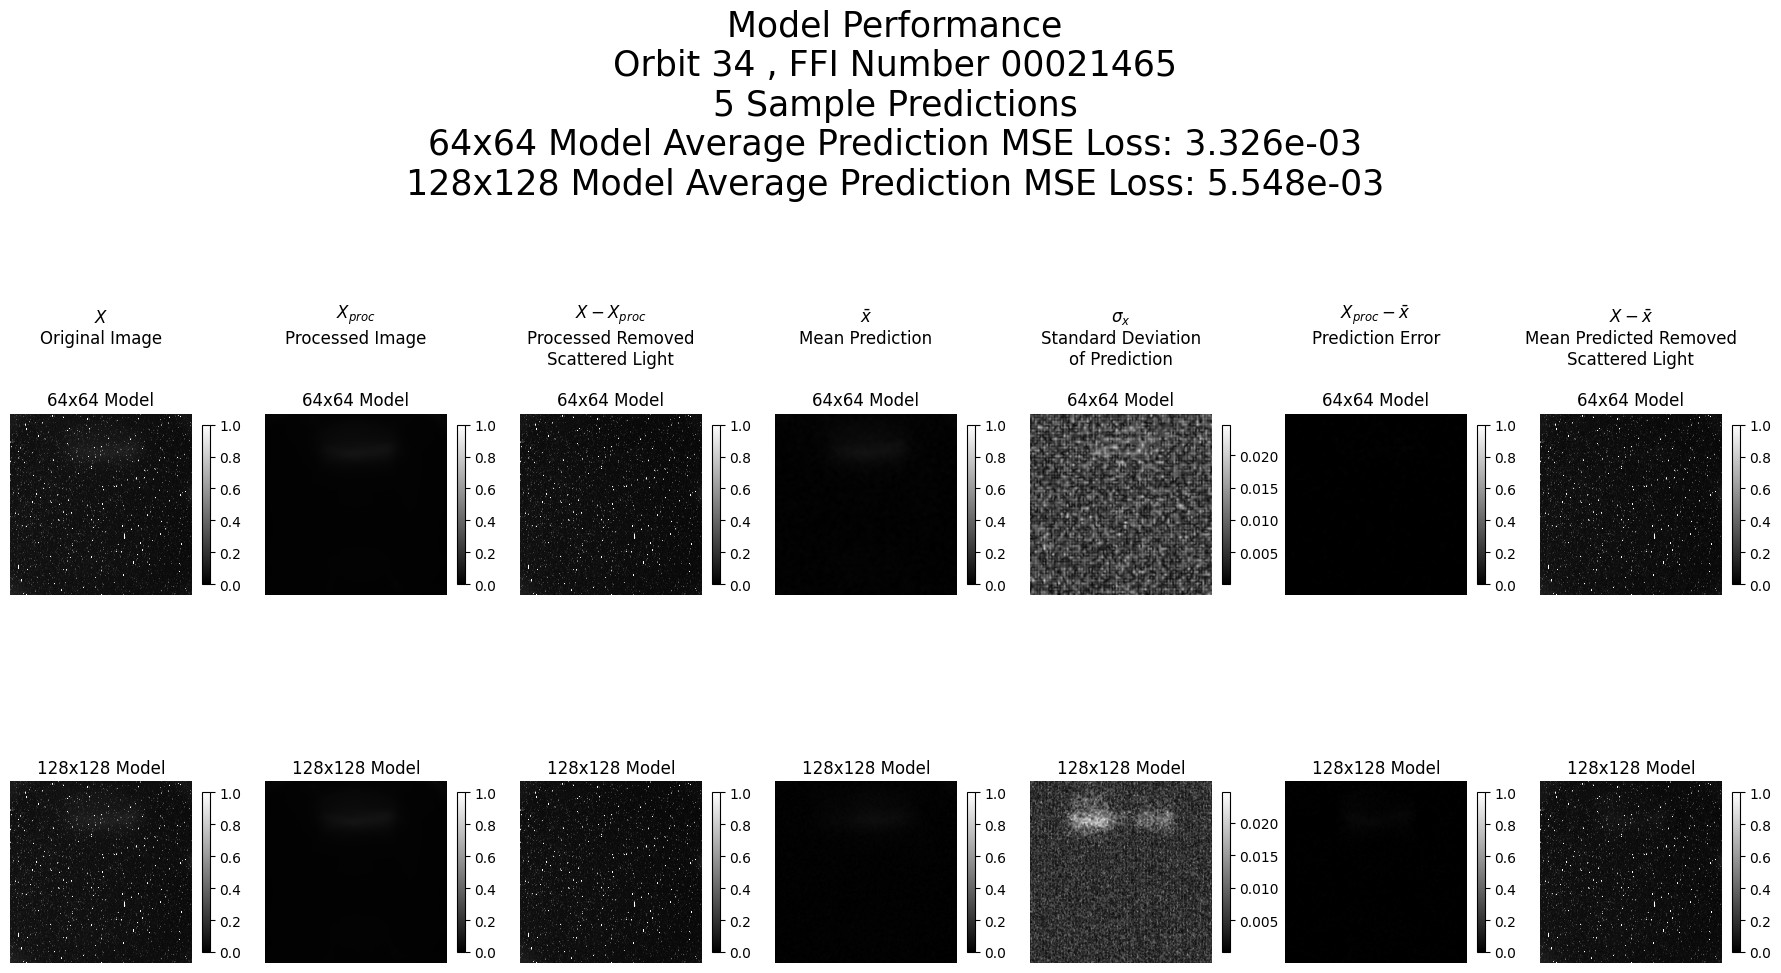

saved image at /pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im128x128_multipleGPUs_1/eval_compare/eval_0_00021465.pdf


Process Process-160:
Process Process-156:
Process Process-159:
Process Process-158:
Process Process-157:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd20cc84160>
Traceback (most recent call last):
  File "/pdo/users/jlupoiii/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/pdo/users/jlupoiii/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/pdo/users/dmuth/miniconda3/envs/pytorch_env/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/pdo/users/dmuth/miniconda3/envs/pytorch_env/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/pdo/users/dmuth/miniconda3/envs/pytorch_env/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selec

In [13]:
def display_TESS_two_models():

    # directory to which files are being saved
    eval_folder_path = "/pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im128x128_multipleGPUs_1/eval_compare"
    os.makedirs(eval_folder_path, exist_ok=True)

    # hardcoding these here - make sure these match the parameters of the model being loaded
    # model parameters for 64x64 model
    n_T_64 = 600
    device_64 = "cuda:5"
    n_feat_64 = 256
    lrate_64 = 1e-4
    model_dir_64 = "/pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im64x64_multipleGPUs_1/"
    model_state_dic_filename_64 = "model_epoch1499.pth"    
    angle_filename_64 = 'angles_O11-54_data_dic.pkl'
    ccd_folder_64 = "/pdo/users/jlupoiii/TESS/data/processed_images_im64x64/"
    image_shape_64 = (64,64)
    num_processes_64 = 5

    # hardcoding these here - make sure these match the parameters of the model being loaded
    # model parameters for 128x128 model
    n_T_128 = 600
    device_128 = "cuda:6"
    n_feat_128 = 256
    lrate_128 = 1e-4
    model_dir_128 = "/pdo/users/jlupoiii/TESS/model_conditional_diffusion/model_TESS/model_TESS_O11-54_im128x128_multipleGPUs_1/"
    model_state_dic_filename_128 = "model_epoch1499.pth"    
    # dataset parameters
    angle_filename_128 = 'angles_O11-54_data_dic.pkl'
    ccd_folder_128 = "/pdo/users/jlupoiii/TESS/data/processed_images_im128x128/"
    image_shape_128 = (128,128)
    num_processes_128 = 5

    N = 100 # number of samples to predict per datapoint

    # loading class that handles getting the 4096x4096 images based on the ffi
    ffi_to_4096originalimage = TESS_4096_original_images()

    # define models
    ddpm_64 = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat_64), betas=(1e-4, 0.02), n_T=n_T_64, device=device_64, drop_prob=0.1)
    ddpm_128 = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat_128), betas=(1e-4, 0.02), n_T=n_T_128, device=device_128, drop_prob=0.1)
    
    # load a model
    ddpm_64.load_state_dict(torch.load(os.path.join(model_dir_64, model_state_dic_filename_64)))
    ddpm_64.to(device_64)
    ddpm_128.load_state_dict(torch.load(os.path.join(model_dir_128, model_state_dic_filename_128)))
    ddpm_128.to(device_128)

    print(f"loading models from {os.path.join(model_dir_64, model_state_dic_filename_64)} and {os.path.join(model_dir_64, model_state_dic_filename_64)}")

    # load daatset and dataloader for images in validation set that are above the sunshade
    dataset_64 = TESSDataset(angle_filename=angle_filename_64, ccd_folder=ccd_folder_64, model_dir=model_dir_64, image_shape=image_shape_64, num_processes=num_processes_64, above_sunshade=True, validation_dataset=True)
    dataloader_64 = DataLoader(dataset_64, batch_size=1, shuffle=True, num_workers=5, drop_last=True)
    dataset_128 = TESSDataset(angle_filename=angle_filename_128, ccd_folder=ccd_folder_128, model_dir=model_dir_128, image_shape=image_shape_128, num_processes=num_processes_128, above_sunshade=True, validation_dataset=True)
    dataloader_128 = DataLoader(dataset_128, batch_size=1, shuffle=True, num_workers=5, drop_last=True)

    ddpm_64.eval()
    ddpm_128.eval()
    with torch.no_grad():
        count = 0        
        for data_dic_128 in dataloader_128:
            ffi_num = data_dic_128['ffi_num'][0]
            orbit = data_dic_128['orbit'][0]

            # ensures that the images are the same that are used in both the 64 and 128 model.
            # only a fraction of images are above the sunshade and in the validation set, so
            # the datasets may have many differing ffi_nums
            data_dic_64 = {}
            for data_dic_64_temp in dataloader_64:
                if data_dic_64_temp['ffi_num'][0] == ffi_num: # matching ffi_num was found!
                    data_dic_64 = data_dic_64_temp
                    break
            if not data_dic_64: # in the case that no matching ffi number was found
                continue
                
            x_128 = data_dic_128['y'].to(device_128)
            c_128 = data_dic_128['x'].to(device_128)
            x_64 = data_dic_64['y'].to(device_64)
            c_64 = data_dic_64['x'].to(device_64)

            print(f'beginnging evaluation for ffi number {ffi_num}, orbit {orbit}')
    
            # get original 4096x4096 image
            X = ffi_to_4096originalimage[ffi_num] # Original Image

            # for clarity, X_proc is the processed image to only show scattered light
            order = 1 # degree of interpolation. 1 is linear, what we want to do
            X_proc_64 = x_64[0].cpu()
            X_proc_upsampled_64 = scipy.ndimage.zoom(X_proc_64.cpu(), (1, 4096//image_shape_64[0], 4096//image_shape_64[0]), order=order)
            X_proc_upsampled_64 = torch.tensor(X_proc_upsampled_64)
            X_proc_128 = x_128[0].cpu()
            X_proc_upsampled_128 = scipy.ndimage.zoom(X_proc_128.cpu(), (1, 4096//image_shape_128[0], 4096//image_shape_128[0]), order=order)
            X_proc_upsampled_128 = torch.tensor(X_proc_upsampled_128)
    
            # generate samples using model, each sample is an x_i
            x_gen_64, x_gen_store_64 = ddpm_64.sample_c(c_64, N, (1, image_shape_64[0], image_shape_64[1]), device_64)
            x_gen_128, x_gen_store_128 = ddpm_128.sample_c(c_128, N, (1, image_shape_128[0], image_shape_128[1]), device_128)
            
            # upscale generated samples. Here, simply repeating pixels to represent the larger area
            x_gen_upsampled_64 = scipy.ndimage.zoom(x_gen_64.cpu(), (1, 1, 4096//image_shape_64[0], 4096//image_shape_64[0]), order=order)
            x_gen_upsampled_64 = torch.tensor(x_gen_upsampled_64)
            x_gen_upsampled_128 = scipy.ndimage.zoom(x_gen_128.cpu(), (1, 1, 4096//image_shape_128[0], 4096//image_shape_128[0]), order=order)
            x_gen_upsampled_128 = torch.tensor(x_gen_upsampled_128)
            
            bar_x_64 = torch.mean(x_gen_upsampled_64, dim=0) # Mean prediction for upsampled predictions
            bar_x_128 = torch.mean(x_gen_upsampled_128, dim=0)

            # bar_x_gen = torch.mean(x_gen, dim=0) # Mean prediction for non-upsampled predictions

            sigma_x_64 = torch.std(x_gen_upsampled_64, dim=0) # Standard deviation of prediction
            sigma_x_128 = torch.std(x_gen_upsampled_128, dim=0)

            avg_pred_MSE_Loss_64 = torch.std((X_proc_upsampled_64 - bar_x_64)[0]) # MSE for average predicted image
            avg_pred_MSE_Loss_128 = torch.std((X_proc_upsampled_128 - bar_x_128)[0])
            
            # make plot of each image 
            # fig, axes = plt.subplots(2, 7, figsize=(18, 6)) # , subplot_kw={'aspect': 'equal'})
            fig, axes = plt.subplots(2, 7, figsize=(18, 12)) # , subplot_kw={'aspect': 'equal'})

            fig.suptitle(f"Model Performance\nOrbit {orbit} , FFI Number {ffi_num}\n{N} Sample Predictions\n64x64 Model Average Prediction MSE Loss: {avg_pred_MSE_Loss_64:.3e}\n128x128 Model Average Prediction MSE Loss: {avg_pred_MSE_Loss_128:.3e}", fontsize = 25)

            # X
            img00 = axes[0,0].imshow(X, cmap='gray', vmin=0, vmax=1)
            axes[0,0].set_title(r"$X$" + "\nOriginal Image\n\n\n64x64 Model")
            axes[0,0].axis('off')
            fig.colorbar(img00, ax=axes[0,0], fraction=0.04)
            
            img10 = axes[1,0].imshow(X, cmap='gray', vmin=0, vmax=1)
            # axes[1,0].set_title(r"$X$" + "\nOriginal Image")
            axes[1,0].set_title("128x128 Model")
            axes[1,0].axis('off')
            fig.colorbar(img00, ax=axes[1,0], fraction=0.04)

            # X_proc
            img01 = axes[0,1].imshow(X_proc_64[0], cmap='gray', vmin=0, vmax=1)
            axes[0,1].set_title(r"$X_{proc}$" + "\nProcessed Image\n\n\n64x64 Model")
            axes[0,1].axis('off')
            fig.colorbar(img01, ax=axes[0,1], fraction=0.04)

            img11 = axes[1,1].imshow(X_proc_128[0], cmap='gray', vmin=0, vmax=1)
            # axes[1,1].set_title(r"$X_{proc}$" + "\nProcessed Image")
            axes[1,1].set_title("128x128 Model")
            axes[1,1].axis('off')
            fig.colorbar(img01, ax=axes[1,1], fraction=0.04)

            # X-X_proc
            img02 = axes[0,2].imshow(X-X_proc_upsampled_64[0], cmap='gray', vmin=0, vmax=1)
            axes[0,2].set_title(r"$X-X_{proc}$" + "\nProcessed Removed\nScattered Light\n\n64x64 Model")
            axes[0,2].axis('off')
            fig.colorbar(img02, ax=axes[0,2], fraction=0.04)

            img12 = axes[1,2].imshow(X-X_proc_upsampled_128[0], cmap='gray', vmin=0, vmax=1)
            # axes[1,2].set_title(r"$X-X_{proc}$" + "\nProcessed Removed\nScattered Light")
            axes[1,2].set_title("128x128 Model")
            axes[1,2].axis('off')
            fig.colorbar(img02, ax=axes[1,2], fraction=0.04)

            # bar(x)
            img03 = axes[0,3].imshow(bar_x_64[0], cmap='gray', vmin=0, vmax=1)
            axes[0,3].set_title(r"$\bar{x}$" + "\nMean Prediction\n\n\n64x64 Model")
            axes[0,3].axis('off')
            fig.colorbar(img03, ax=axes[0,3], fraction=0.04)

            img13 = axes[1,3].imshow(bar_x_128[0], cmap='gray', vmin=0, vmax=1)
            # axes[1,3].set_title(r"$\bar{x}$" + "\nMean Prediction")
            axes[1,3].set_title("128x128 Model")
            axes[1,3].axis('off')
            fig.colorbar(img03, ax=axes[1,3], fraction=0.04)
            
            # sigma_x
            img04 = axes[0,4].imshow(sigma_x_64[0], cmap='gray')
            axes[0,4].set_title(r"$\sigma_x$" + "\nStandard Deviation\nof Prediction\n\n64x64 Model")
            axes[0,4].axis('off')
            fig.colorbar(img04, ax=axes[0,4], fraction=0.04)

            img14 = axes[1,4].imshow(sigma_x_128[0], cmap='gray')
            # axes[1,4].set_title(r"$\sigma_x$" + "\nStandard Deviation\nof Prediction")
            axes[1,4].set_title("128x128 Model")
            axes[1,4].axis('off')
            fig.colorbar(img04, ax=axes[1,4], fraction=0.04)

            # X_proc - bar(x)
            img05 = axes[0,5].imshow(X_proc_upsampled_64[0]-bar_x_64[0], cmap='gray', vmin=0, vmax=1)
            axes[0,5].set_title(r"$X_{proc} - \bar{x}$" + "\nPrediction Error\n\n\n64x64 Model")
            axes[0,5].axis('off')
            fig.colorbar(img05, ax=axes[0,5], fraction=0.04)

            img15 = axes[1,5].imshow(X_proc_upsampled_128[0]-bar_x_128[0], cmap='gray', vmin=0, vmax=1)
            # axes[1,5].set_title(r"$X_{proc} - \bar{x}$" + "\nPrediction Error")
            axes[1,5].set_title("128x128 Model")
            axes[1,5].axis('off')
            fig.colorbar(img05, ax=axes[1,5], fraction=0.04)

            # X - bar(x)
            img06 = axes[0,6].imshow(X-bar_x_64[0], cmap='gray', vmin=0, vmax=1)
            axes[0,6].set_title(r"$X - \bar{x}$" + "\nMean Predicted Removed\nScattered Light\n\n64x64 Model")
            axes[0,6].axis('off')
            fig.colorbar(img06, ax=axes[0,6], fraction=0.04)

            img16 = axes[1,6].imshow(X-bar_x_128[0], cmap='gray', vmin=0, vmax=1)
            # axes[1,6].set_title(r"$X - \bar{x}$" + "\nMean Predicted Removed\nScattered Light")
            axes[1,6].set_title("128x128 Model")
            axes[1,6].axis('off')
            fig.colorbar(img06, ax=axes[1,6], fraction=0.04)
            
            # Adjust layout
            plt.tight_layout()
            
            # Show the plot
            plt.show()
            
            # save images
            plt.tight_layout()
            fig.savefig(os.path.join(eval_folder_path, f"eval_{count}_{ffi_num}.pdf"))
            print('saved image at ' + os.path.join(eval_folder_path, f"eval_{count}_{ffi_num}.pdf"))
            plt.close()

            count += 1
            if count == 100: break
            

if __name__ == "__main__":
    display_TESS_two_models()